In [0]:
# !pip install hyperopt

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import date, timedelta
from itertools import product
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
import xgboost as xgb 
from xgboost import plot_importance 
from sklearn import metrics 
from math import sqrt 
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from typing import List

In [0]:
from google.colab import drive 
drive.mount("/content/gdrive", force_remount=True)
  
%cd "/content/gdrive/My Drive/Data_Mining_Cup/"

# %cd /Users/minwu1/Desktop/SS2019:2020/Data_Mining_Seminar/

Mounted at /content/gdrive
/content/gdrive/My Drive/Data_Mining_Cup


In [0]:
static_data = pd.read_pickle("05 Code/data/static_features.pk")

In [0]:
dynamic_data = pd.read_pickle("05 Code/data/dynamic_features_final.pk")

In [0]:
dynamic_data

order  salesPrice  ...  de_holidays  salesPrice_bucket
itemID date                           ...                                
1      2018-01-01    0.0        3.11  ...        False                  0
       2018-01-02    0.0        3.11  ...        False                  0
       2018-01-03    0.0        3.11  ...        False                  0
       2018-01-04    0.0        3.11  ...        False                  0
       2018-01-05    0.0        3.11  ...        False                  0
...                  ...         ...  ...          ...                ...
10463  2018-07-10    0.0      282.16  ...        False                  9
       2018-07-11    0.0      282.16  ...        False                  9
       2018-07-12    0.0      282.16  ...        False                  9
       2018-07-13    0.0      282.16  ...        False                  9
       2018-07-14    0.0      282.16  ...        False                  9

[2040285 rows x 11 columns]

In [0]:
# data = dynamic_data.join(static_data.drop('avg_salesPrice_nonunique', axis=1), on="itemID")
data = dynamic_data.join(static_data, on="itemID")
data = data.reset_index()

In [0]:
data.columns

Index(['itemID', 'date', 'order', 'salesPrice', 'promoted', 'day_of_year',
       'day_of_month', 'month', 'week_nr', 'day_of_week', 'daily_sold',
       'de_holidays', 'salesPrice_bucket', 'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice', 'avg_salesPrice_nonunique', 'has_rating',
       'recommendedRetailPrice_bucket', 'avg_sold_day',
       'avg_sold_day_only_nonzero', 'std_sold_day_only_nonzero',
       'bought_together_cluster'],
      dtype='object')

# Adding the label

After this step, data does not exist. Only X, y left

In [0]:
# This list describes what we want to predict.
labels: List[str] = ["daily_sold"]

##########################
#########################
# We need to put date also into y to make the split
# We also need itemID for the evaluation function to be able to get the price of the item

# _y = data[['date', 'itemID', *labels]].copy()
# # Encode itemID and daily_sold: `daily_sold << 14 + itemID`
# _y['y_true_encoded'] = _y.apply(lambda x: (int(x[2]) << 14) + x[1], axis=1)
# y = _y.drop(['itemID', *labels], axis=1)

y = data[['date', *labels]].copy()
X = data.drop(labels, axis=1).copy()
# del data

# Deletion of unused feature


In [0]:
# Here we can specify the list of unwanted features. The black sheep of features.
# But node the feature "date", we will delete lateron (if wanted). Anyways we need it 
# for splitting up the whole stuff
columns_to_delete: List[str] = ['itemID', 'recommendedRetailPrice_bucket', 'salesPrice_bucket']


##########################
#########################
try:
  # do the deletion
  X = X.drop(columns_to_delete, axis=1)
except KeyError as e:
  print(f"I could not delete the columns {e} cause they were not there. \n But hey, they are gone, like intented :D") 

# Split into train/val/test

In [0]:
def split(X,y,training_end, validation_end, testing_end, split_feature='date', delete_split_feature=True):
  # Training
  print(f"CREATING TRAINING from [begin, {training_end}]")
  train_X = X[X[split_feature] <= training_end]
  train_y = y[y[split_feature] <= training_end]

  # Validation
  print(f"CREATING VALIDATION from ({training_end}, {validation_end}]")
  val_X = X[(X[split_feature] > training_end)]
  val_X = val_X[(val_X[split_feature] <= validation_end)]
  val_y = y[(y[split_feature]> training_end)]
  val_y = val_y[(val_y[split_feature] <= validation_end)]

   # Testing
  print(f"CREATING TESTING from ({validation_end}, {testing_end}]")
  test_X = X[X[split_feature] >= testing_end]
  test_y = y[y[split_feature] >= testing_end]

  if delete_split_feature:
    train_X = train_X.drop(split_feature, axis=1)
    train_y = train_y.drop(split_feature, axis=1)
    val_X = val_X.drop(split_feature, axis=1)
    val_y = val_y.drop(split_feature, axis=1)  # TYPO IN ORIGINAL NOTEBOOK (val_Y with capital Y)
    test_X = test_X.drop(split_feature, axis=1)
    test_y = test_y.drop(split_feature, axis=1)
  
  return (train_X, train_y), (val_X, val_y), (test_X, test_y)

train, val, test = split(X,y, '20180318', '20180411', '20180615')
del X
del y

CREATING TRAINING from [begin, 20180318]
CREATING VALIDATION from (20180318, 20180411]
CREATING TESTING from (20180411, 20180615]


In [0]:
x_train, y_train = train
x_test, y_test = test 
x_val, y_val = val 

# XGBoost Regressor Model

### Custom Eval Metric 

The evaluation function is implemented as proposed by the competition. I implemented the objective function in a slightly different way:

Reasons:
- The original function is composed of two linear functions (one for too high prediction, one for too low).
- Therefore, the gradient is either 1 or -0.6 (depends on whether the prediction was too high or too low).
- The second gradient (hessian) is always 0.
- All this led to oscillating behaviour of the model (prediction too high -> too low -> too high -> too low ...)

What did I do to make it better?
- I calculated the first and second derivative based on the quadratic version of the original function (This doesn't change the optimum of the function).
- This made gradients "nicer" (they get scaled with the distance to the optimum) - if the prediction is very wrong, the gradient is big, and if the prediction is really good, the gradient is small (but I guess you know how gradients work :) )

(by Karin)

In [0]:
from sklearn.metrics import make_scorer

def custom_loss(y_pred, y_true):
    # here I'm not sure why when doing grid search, y_pred is an DataFrame object and y_true is a ndarray
    # when fitting the model with the best parameters, y_pred is ndarray and y_true is DMatrix 
    # however, this if statement should do the trick..
    if isinstance(y_pred, pd.DataFrame):
      y_pred = y_pred.iloc[:,0] 
    else:
      y_true = y_true.get_label()
      
    item_price = 1
    revenue = np.zeros_like(y_true)

    mask1 = y_pred <= y_true
    revenue[mask1] = item_price * y_pred[mask1]

    mask2 = y_pred > y_true
    revenue[mask2] = item_price * (y_true + 0.6 * (y_true - y_pred))[mask2]  # here (y_true - y_pred) is negative 
    
    total_revenue = sum(revenue)
    return "negative-monetary-value", -total_revenue


def custom_objective(y_pred, y_true):
  """
  Squared version of loss
  """
  item_price = 1
  mask1 = y_pred <= y_true
  mask2 = y_pred > y_true

  grad = np.zeros_like(y_pred)
  grad[mask1] = -(-2 * (item_price**2) * y_pred)[mask1]
  grad[mask2] = -(1.2 * item_price * (1.6 * item_price * y_true - 0.6 * item_price * y_pred))[mask2]

  hess = np.zeros_like(y_pred)
  hess[mask1] = -(-2 * (item_price**2))
  hess[mask2] = -(-1.2 * 0.6 * (item_price**2))

  # print(list(zip(y_pred, y_true, grad, hess))[:3])
  return grad, hess

my_custom_score = make_scorer(custom_loss)  # , greater_is_better=True)

### Hyper parameters tuning 

In [0]:
# more parameters can be added here in the parameter space: 
# range can also be changed for more fine tuning 
para_space = {
            'n_estimators': hp.quniform('n_estimators', 10, 20, 1),
            'max_depth': hp.quniform("max_depth", 7, 15, 1),
            'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
            'learning_rate':hp.quniform('learning_rate', 0.05, 0.2, 0.05),  
            'gamma': hp.quniform('gamma', 0.5, 1, 0.1),
            'subsample':hp.quniform('subsample', 0.9, 1, 0.1),
            'eval_metric': my_custom_score, # 'rmse',
            'tree_method':'auto',
            'objective': custom_objective,  # 'reg:squarederror', 
            'seed': 7
        }

In [0]:
def eval_scoring(para_space):
    print("Training with params:", para_space)

    xgb_model = xgb.XGBRegressor(
                          n_estimators = int(para_space['n_estimators']), 
                          max_depth = int(para_space['max_depth']),
                          min_child_weight=int(para_space['min_child_weight']),
                          learning_rate = para_space['learning_rate'],
                          gamma = para_space['gamma'],
                          subsample = para_space['subsample'],
                          feval = para_space['eval_metric'],  # Typo in original notebook; feval instead of eval_metric
                          tree_method = para_space['tree_method'],
                          objective = para_space['objective'],
                          seed = para_space['seed']
                         )
    
    eval_set = [train, val]
    
    xgb_model.fit(train[0], train[1], eval_set = eval_set, early_stopping_rounds = 10, verbose = False)

    train_pred = xgb_model.predict(train[0])
    train_rmse = sqrt(metrics.mean_squared_error(train[1], train_pred))

    val_pred = xgb_model.predict(val[0])
    val_rmse = sqrt(metrics.mean_squared_error(val[1], val_pred))
    monetary_value = custom_loss(val[1], val_pred)
    
    print("Train RMSE: ", train_rmse)
    print("Val RMSE: ", val_rmse)
    print("Monetary value: ", monetary_value)
    
    return {'loss':val_rmse, 'status': STATUS_OK }

In [0]:
def hyperpara_tuning(para_space):
    """
    Returns the best set of hyperparamters, 
    given a parameter space and a evaluation function 
    """
    
    best_model = fmin(fn=eval_scoring,
                      space=para_space,
                      algo=tpe.suggest,
                      max_evals= 30 # para can be changed here 
                     )
    
    return best_model 

In [0]:
# set runtime environment to GPU at: Runtime -> Change runtime type 

best_hyperparams = hyperpara_tuning(para_space)

Training with params:
{'eval_metric': make_scorer(custom_loss), 'gamma': 0.8, 'learning_rate': 0.15000000000000002, 'max_depth': 12.0, 'min_child_weight': 2.0, 'n_estimators': 18.0, 'objective': <function custom_objective at 0x7fec6b442a60>, 'seed': 7, 'subsample': 0.9, 'tree_method': 'auto'}
[18:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 
27.839029410117654
Val RMSE: 
32.23324335391112
Monetary value: 
('negative-monetary-value', 319508.37680497766)
Training with params:
{'eval_metric': make_scorer(custom_loss), 'gamma': 0.7000000000000001, 'learning_rate': 0.2, 'max_depth': 14.0, 'min_child_weight': 4.0, 'n_estimators': 17.0, 'objective': <function custom_objective at 0x7fec6b442a60>, 'seed': 7, 'subsample': 1.0, 'tree_method': 'auto'}
[18:23:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 
29.022095790558005
V

In [0]:
print(best_hyperparams)

{'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 7.0, 'min_child_weight': 5.0, 'n_estimators': 11.0, 'subsample': 0.9}


### final xgb model based on Grid Search

In [0]:
def best_xgb_model(x_train, y_train, x_val, y_val, best_hyperparams):
  xgb_model = xgb.XGBRegressor(n_estimators = int(best_hyperparams['n_estimators']), 
                               learning_rate = best_hyperparams['learning_rate'], 
                               gamma = best_hyperparams['gamma'],
                               max_depth = int(best_hyperparams['max_depth']), 
                               min_child_weight = int(best_hyperparams['min_child_weight']),
                               subsample = best_hyperparams['subsample'],
                               tree_metric = 'gpu_hist', 
                               objective = custom_objective,
                               feval = my_custom_score,
                               seed = 7)

  xgb_model.fit(train[0], train[1], verbose = True, eval_metric = custom_loss, eval_set = [train, val])
    
  return xgb_model

In [0]:
final_xgb_model = best_xgb_model(train[0], train[1], val[0], val[1], best_hyperparams)

[18:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25.5065	validation_1-rmse:29.4969	validation_0-negative-monetary-value:260311	validation_1-negative-monetary-value:83098.2
[1]	validation_0-rmse:26.8279	validation_1-rmse:31.0469	validation_0-negative-monetary-value:305504	validation_1-negative-monetary-value:104504
[2]	validation_0-rmse:28.3163	validation_1-rmse:32.793	validation_0-negative-monetary-value:356556	validation_1-negative-monetary-value:128688
[3]	validation_0-rmse:30.0019	validation_1-rmse:34.7703	validation_0-negative-monetary-value:414362	validation_1-negative-monetary-value:156067
[4]	validation_0-rmse:31.8969	validation_1-rmse:36.9921	validation_0-negative-monetary-value:479694	validation_1-negative-monetary-value:187000
[5]	validation_0-rmse:34.0448	validation_1-rmse:39.5124	validation_0-negative-monetary-value:553631	validation_1-negative-monetary-value:222031
[6]	valid

### Model Results 

In [0]:
train_predictions = final_xgb_model.predict(x_train)
train_predictions = [round(i) for i in train_predictions]
print("Train RMSE : %.8g" % sqrt(metrics.mean_squared_error(y_train, train_predictions)))

val_predictions = final_xgb_model.predict(x_val)
val_predictions = [round(i) for i in val_predictions]
print("Val RMSE : %.8g" % sqrt(metrics.mean_squared_error(y_val, val_predictions)))

Train RMSE : 49.814805
Val RMSE : 57.989096


In [0]:
pred = final_xgb_model.predict(x_train)
comparison = list(zip(pred, y_train.values))

print(set(pred))

{0.5, 0.8702059, -0.24004745, -2293.374, -110.63604, -875.6787, -2153.7134, -1249.8457, -222.18715, -88.8146, -326.28534, -69.837685, -189.60466, -186.19475, -55.865776, -47.172333, -427.51474, -41.04266, -679.76044, -32.87757, -160.29222, -543.60986, -25.654564, -19.988396, -131.7555, -15.164747, -12.64194, -10.578523, -8.561375, -6.140879, -260.94385, -3.9748058, -2.4511843, -1.3481002}


In [0]:
pred

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5], dtype=float32)

In [0]:
pred_test = final_xgb_model.predict(x_test)

In [0]:
pred_test

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5], dtype=float32)

In [0]:
x_test['prediction'] = pred_test

In [0]:
x_test['ground_truth'] = y_test

In [0]:
x_test['prediction'] = x_test['prediction'].astype(int)

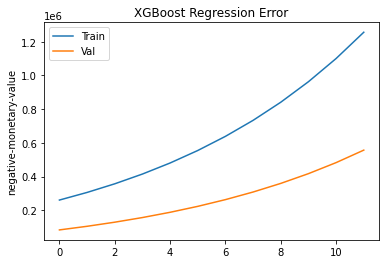

In [0]:
results = final_xgb_model.evals_result()
metric = 'negative-monetary-value'  # 'rmse'
epochs = len(results['validation_0'][metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0'][metric], label='Train')
ax.plot(x_axis, results['validation_1'][metric], label='Val')
ax.legend()
plt.ylabel(metric)
plt.title('XGBoost Regression Error')
plt.show()

In [0]:
print(results['validation_0'][metric])
print(results['validation_1'][metric])

[260403.994284, 305624.468148, 356800.214469, 414715.614134, 480258.37178, 554433.135638, 638376.905004, 733376.443294, 840888.04068, 962559.836694, 1100257.096375, 1256090.826693]
[83214.014773, 104715.806921, 129049.356708, 156587.657916, 187752.840573, 223022.647173, 262937.762928, 308110.094548, 359232.170719, 417087.759712, 482563.889282, 556664.455238]


In [0]:
ax = plot_importance(final_xgb_model)
fig = ax.figure
fig.set_size_inches(9, 6)


# Booster.get_score() results in empty
# error message suggesting the model isn't trained...

ValueError: ignored

### Test custom eval and obj function

In [0]:
def test_eval(y_true, y_pred):
  return "test_eval", y_true - y_pred

In [0]:
def test_obj(y_true, y_pred):
  return np.ones_like(y_true), np.ones_like(y_true)

In [0]:
test_xgb_model = xgb.XGBRegressor(
    feval = test_eval,
    objective = test_obj,
)

In [0]:
test_xgb_model.fit(x_train, y_train, verbose = True)